In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
from hmmlearn import hmm

/tmp/ipykernel_5741/574121967.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
_divergence_df = pd.read_csv('data/_divergence_df_X_1h_clean.csv', index_col='closetime', parse_dates=True)

In [11]:
_divergence_df

,slope_diff_EMAs,slope_diff_RSIs,returns,HMM_Signals,Buy,Sell,diff_vol
closetime,,,,,,,
2020-02-01 04:59:59.999,-7.201719e-18,-2.993936e-12,0.002369,1,0,0,NaN
2020-02-01 05:59:59.999,1.549511e-17,5.974475e-13,-0.002733,1,0,0,-0.118824
2020-02-01 06:59:59.999,8.862290e-20,-1.226863e-12,-0.000365,1,0,1,-0.027216
2020-02-01 07:59:59.999,-2.257050e-17,-4.840415e-12,0.002552,1,0,0,-0.214609
2020-02-01 08:59:59.999,-8.854276e-18,4.798299e-13,-0.015228,1,1,0,0.417241
...,...,...,...,...,...,...,...
2024-03-20 19:59:59.999,-4.914897e-16,7.374007e-13,0.013699,0,1,0,-0.057249
2024-03-20 20:59:59.999,-4.068745e-16,-1.556345e-12,0.008036,0,0,0,-0.071865
2024-03-20 21:59:59.999,2.765075e-17,1.414649e-13,0.005166,0,0,0,-0.973190


In [10]:
_divergence_df['diff_vol'] = np.log(_divergence_df['Volume']).diff()
_divergence_df.drop(['Volume', 'divergence_signal', 'Close', 'MACD', 'Hold'], axis=1, inplace=True)

In [7]:
_divergence_df.columns

Index(['MACD', 'slope_diff_EMAs', 'slope_diff_RSIs', 'returns', 'HMM_Signals',
       'Buy', 'Hold', 'Sell', 'diff_vol'],
      dtype='object')

In [4]:
hmm_X = _divergence_df['returns'].to_numpy().reshape(-1,1)

In [5]:
hmm_model = hmm.GaussianHMM(n_components=2, covariance_type='diag', tol=0.01, min_covar=0.0001)

In [6]:
hmm_model.fit(hmm_X)

GaussianHMM(min_covar=0.0001, n_components=2)

In [7]:
hmm_Z = hmm_model.predict(hmm_X)

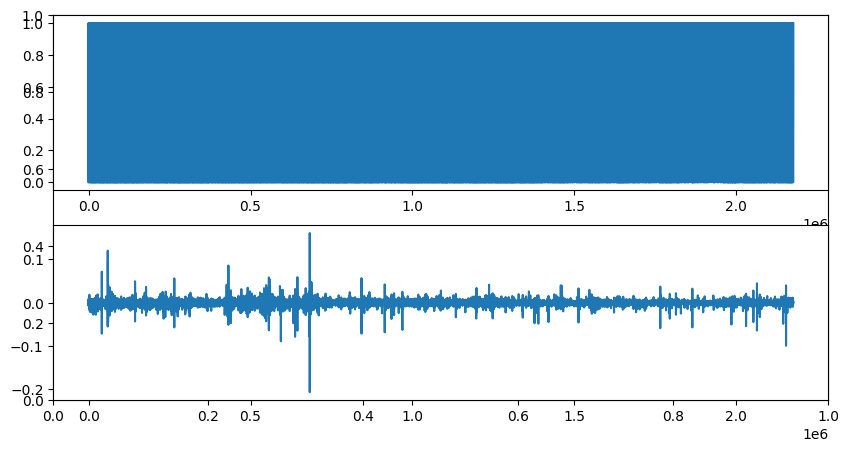

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(hmm_Z)
plt.subplot(212)
plt.plot(hmm_X)

In [9]:
hmm_model.transmat_

array([[0.69011875, 0.30988125],
       [0.07504768, 0.92495232]])

In [10]:
hmm_model.transmat_ = np.array([
  [0.9999, 0.0001],
  [0.0001, 0.9999]
])

In [ ]:
hmm_Z = hmm_model.predict(hmm_X)

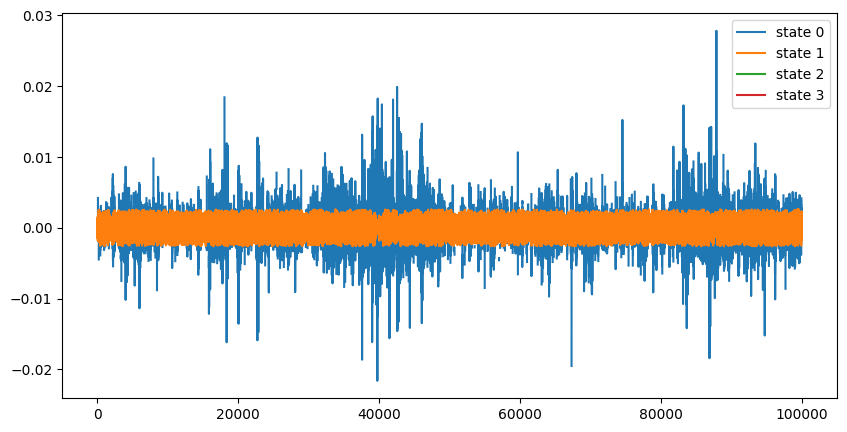

In [11]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(hmm_Z))
returns1 = np.empty(len(hmm_Z))
returns2 = np.empty(len(hmm_Z))
returns3 = np.empty(len(hmm_Z))
# returns4 = np.empty(len(hmm_Z))
returns0[:] = np.nan
returns1[:] = np.nan
returns2[:] = np.nan
returns3[:] = np.nan
# returns4[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[hmm_Z == 0] = _divergence_df['returns'][hmm_Z == 0]
returns1[hmm_Z == 1] = _divergence_df['returns'][hmm_Z == 1]
returns2[hmm_Z == 2] = _divergence_df['returns'][hmm_Z == 2]
returns3[hmm_Z == 3] = _divergence_df['returns'][hmm_Z == 3]
# returns4[hmm_Z == 4] = _divergence_df['returns'][hmm_Z == 4]
plt.plot(returns0[1000000:1100000], label='state 0')
plt.plot(returns1[1000000:1100000], label='state 1')
plt.plot(returns2[1000000:1100000], label='state 2')
plt.plot(returns3[1000000:1100000], label='state 3')
# plt.plot(returns4, label='state 4')
plt.legend()

In [12]:
_divergence_df['HMM_Signals'] = hmm_Z
_divergence_df = pd.concat([_divergence_df, pd.get_dummies(_divergence_df['HMM_Signals'], prefix='state_').copy()], axis=1)
_divergence_df.drop('HMM_Signals', axis=1, inplace=True)

### Teste da nova base em 1 hora

In [5]:
_divergence_df.columns

Index(['MACD', 'slope_diff_EMAs', 'slope_diff_RSIs', 'returns', 'HMM_Signals',
       'Buy', 'Hold', 'Sell', 'diff_vol'],
      dtype='object')

In [13]:
def keep_cols(cols_name: list, data: pd.DataFrame) -> pd.DataFrame:
  _data_cols = data.columns
  for col in cols_name:
    if col in _data_cols:
      _data_cols = _data_cols.delete(_data_cols.get_loc(col))
  data.drop(_data_cols, axis=1, inplace=True)
  data.sort_index(ascending=True, inplace=True)
  return data

In [14]:
_divergence_df_X = keep_cols(['volume_diff', 'returns', 'diff_EMAs', 'diff_RSIs', 'signal_diff_EMAs__0.0',
       'signal_diff_EMAs__1.0', 'signal_diff_RSIs__0.0', 'signal_diff_RSIs__1.0', 'slope_diff_EMAs', 'slope_diff_RSIs', 'state__0', 'state__1', 'state__2', 'state__3'], data=_divergence_df.iloc[60:-1,].copy())
_divergence_df_Y = keep_cols(['target__0.0', 'target__1.0'], data=_divergence_df.iloc[60:-1,].copy())

In [6]:
feats = ['MACD', 'slope_diff_EMAs', 'slope_diff_RSIs', 'returns', 'HMM_Signals',
       'Buy', 'Hold', 'Sell', 'diff_vol']

In [7]:
# split into train and test
Ntest = int(len(_divergence_df) * 0.6)
train_data = _divergence_df.iloc[:-Ntest]
test_data = _divergence_df.iloc[-Ntest:]

In [1]:
class Env:
  def __init__(self, df):
    self.df = df
    self.n = len(df)
    self.current_idx = 0
    self.action_space = [0, 1, 2] # BUY, SELL, HOLD
    self.invested = 0

    self.states = self.df[feats].to_numpy()
    self.rewards = self.df['returns'].to_numpy()

  def reset(self):
    self.current_idx = 0
    return self.states[self.current_idx]

  def step(self, action):
    # need to return (next_state, reward, done)

    self.current_idx += 1
    if self.current_idx >= self.n:
      raise Exception("Episode already done")

    if (action == 0) & (self.invested == 0): # BUY with FLAT
      self.invested = 1
      reward = self.rewards[self.current_idx]
    elif (action == 0) & (self.invested == 1): # BUY with SHORT
      self.invested = 0
      reward = -self.rewards[self.current_idx]
    elif (action == 1) & (self.invested == 0): # SELL with FLAT
      self.invested = 1
      reward = -self.rewards[self.current_idx]
    elif (action == 1) & (self.invested == 1): # SELL with LONG
      self.invested = 0
      reward = self.rewards[self.current_idx]
    else:
      reward = 0

    # # compute reward
    # if self.invested:
    #   reward = self.rewards[self.current_idx]
    # else:
    #   reward = 0

    # state transition
    next_state = self.states[self.current_idx]

    done = (self.current_idx == self.n - 1)
    return next_state, reward, done

In [9]:
class StateMapper:
  def __init__(self, env, n_bins=10, n_samples=1000):
    # first, collect sample states from the environment
    states = []
    done = False
    s = env.reset()
    self.D = len(s) # number of elements we need to bin
    states.append(s)
    while True:
      a = np.random.choice(env.action_space)
      s2, _, done = env.step(a)
      states.append(s2)
      if len(states) >= n_samples:
        break
      if done:
        s = env.reset()
        states.append(s)
        if len(states) >= n_samples:
          break

    # convert to numpy array for easy indexing
    states = np.array(states)

    # create the bins for each dimension
    self.bins = []
    for d in range(self.D):
      column = np.sort(states[:,d])

      # find the boundaries for each bin
      current_bin = []
      for k in range(n_bins):
        boundary = column[int(n_samples / n_bins * (k + 0.5))]
        current_bin.append(boundary)

      self.bins.append(current_bin)


  def transform(self, state):
    x = np.zeros(self.D)
    for d in range(self.D):
      x[d] = int(np.digitize(state[d], self.bins[d]))
    return tuple(x)


  def all_possible_states(self):
    list_of_bins = []
    for d in range(self.D):
      list_of_bins.append(list(range(len(self.bins[d]) + 1)))
    # print(list_of_bins)
    return itertools.product(*list_of_bins)

In [10]:
class Agent:
  def __init__(self, action_size, state_mapper):
    self.action_size = action_size
    self.gamma = 0.8  # discount rate
    self.epsilon = 0.1
    self.learning_rate = 1e-1
    self.state_mapper = state_mapper

    # initialize Q-table randomly
    self.Q = {}
    for s in self.state_mapper.all_possible_states():
      s = tuple(s)
      for a in range(self.action_size):
        self.Q[(s,a)] = np.random.randn()

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)

    s = self.state_mapper.transform(state)
    act_values = [self.Q[(s,a)] for a in range(self.action_size)]
    return np.argmax(act_values)  # returns action

  def train(self, state, action, reward, next_state, done):
    s = self.state_mapper.transform(state)
    s2 = self.state_mapper.transform(next_state)

    if done:
      target = reward
    else:
      act_values = [self.Q[(s2,a)] for a in range(self.action_size)]
      target = reward + self.gamma * np.amax(act_values)

    # Run one training step
    self.Q[(s,action)] += self.learning_rate * (target - self.Q[(s,action)])

In [11]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    total_reward += reward
    if is_train:
      agent.train(state, action, reward, next_state, done)
    state = next_state

  return total_reward

In [12]:
num_episodes = 20000

train_env = Env(train_data)
test_env = Env(test_data)

action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size, state_mapper)

train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

for e in range(num_episodes):
  r = play_one_episode(agent, train_env, is_train=True)
  train_rewards[e] = r

  # test on the test set
  tmp_epsilon = agent.epsilon
  agent.epsilon = 0.
  tr = play_one_episode(agent, test_env, is_train=False)
  agent.epsilon = tmp_epsilon
  test_rewards[e] = tr

  print(f"eps: {e + 1}/{num_episodes}, train: {r:.5f}, test: {tr:.5f}")

plt.plot(train_rewards)
plt.plot(test_rewards)

: 

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import pickle
from hmmlearn import hmm

# %% Carregar e preparar dados
_divergence_df = pd.read_csv('data/_divergence_df_X_1h_clean.csv', index_col='closetime', parse_dates=True)

def keep_cols(cols_name: list, data: pd.DataFrame) -> pd.DataFrame:
    _data_cols = data.columns
    for col in cols_name:
        if col in _data_cols:
            _data_cols = _data_cols.delete(_data_cols.get_loc(col))
    data.drop(_data_cols, axis=1, inplace=True)
    data.sort_index(ascending=True, inplace=True)
    return data

_divergence_df['diff_vol'] = np.log(_divergence_df['Volume']).diff()
_divergence_df = keep_cols(['slope_diff_EMAs', 'slope_diff_RSIs', 'returns', 'HMM_Signals', 'Buy', 'Sell', 'diff_vol'], _divergence_df)

# %% Parâmetros
Ntest = int(len(_divergence_df) * 0.65)
num_episodes = 10000

# %% Divisão dos dados em treino e teste
train_data = _divergence_df.iloc[:-Ntest]
test_data = _divergence_df.iloc[-Ntest:]

# %% Definição do Ambiente
class Env:
    def __init__(self, df):
        self.df = df
        self.n = len(df)
        self.current_idx = 0
        self.action_space = [0, 1, 2]  # BUY, SELL, HOLD
        self.position = 0  # 0: Flat, 1: Long, -1: Short

        self.states = self.df[feats].to_numpy()
        self.rewards = self.df['returns'].to_numpy()

    def reset(self):
        self.current_idx = 0
        self.position = 0
        return self.states[self.current_idx]

    def step(self, action):
        self.current_idx += 1
        if self.current_idx >= self.n:
            raise Exception("Episódio já finalizado")

        reward = 0
        if action == 0:  # BUY
            if self.position == 0:  # Flat -> Long
                self.position = 1
                reward = self.rewards[self.current_idx]
            elif self.position == -1:  # Short -> Flat
                reward = self.rewards[self.current_idx]
                self.position = 0
        elif action == 1:  # SELL
            if self.position == 0:  # Flat -> Short
                self.position = -1
                reward = -self.rewards[self.current_idx]
            elif self.position == 1:  # Long -> Flat
                reward = -self.rewards[self.current_idx]
                self.position = 0
        elif action == 2:  # HOLD
            if self.position == 1:
                reward = self.rewards[self.current_idx]
            elif self.position == -1:
                reward = -self.rewards[self.current_idx]

        next_state = self.states[self.current_idx]
        done = (self.current_idx == self.n - 1)
        return next_state, reward, done

# %% Definição do Mapeador de Estado
class StateMapper:
    def __init__(self, env, n_bins=7, n_samples=100):
        states = []
        s = env.reset()
        self.D = len(s)
        states.append(s)
        while len(states) < n_samples:
            a = np.random.choice(env.action_space)
            s2, _, done = env.step(a)
            states.append(s2)
            if done:
                s = env.reset()

        states = np.array(states)
        self.bins = [np.percentile(states[:, d], np.linspace(0, 100, n_bins + 1)[1:-1]) for d in range(self.D)]

    def transform(self, state):
        return tuple(np.digitize(state[d], self.bins[d]) for d in range(self.D))

    def all_possible_states(self):
        list_of_bins = [list(range(len(self.bins[d]) + 1)) for d in range(self.D)]
        return itertools.product(*list_of_bins)

# %% Definição do Agente
class Agent:
    def __init__(self, action_size, state_mapper):
        self.action_size = action_size
        self.gamma = 0.8
        self.epsilon = 0.1
        self.learning_rate = 1e-1
        self.state_mapper = state_mapper

        self.Q = {(s, a): np.random.randn() for s in state_mapper.all_possible_states() for a in range(action_size)}

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        s = self.state_mapper.transform(state)
        return max(range(self.action_size), key=lambda a: self.Q[(s, a)])

    def train(self, state, action, reward, next_state, done):
        s = self.state_mapper.transform(state)
        s2 = self.state_mapper.transform(next_state)
        target = reward if done else reward + self.gamma * max(self.Q[(s2, a)] for a in range(self.action_size))
        self.Q[(s, action)] += self.learning_rate * (target - self.Q[(s, action)])



In [11]:
# %% Treinamento e Teste
train_env = Env(train_data)
test_env = Env(test_data)

action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size, state_mapper)

train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

best_policy = None
best_test_reward = -np.inf

In [12]:
for e in range(num_episodes):
    train_reward, _ = play_one_episode(agent, train_env, is_train=True)
    train_rewards[e] = train_reward

    # Teste no conjunto de teste
    tmp_epsilon = agent.epsilon
    agent.epsilon = 0.
    test_reward, test_actions = play_one_episode(agent, test_env, is_train=False)
    agent.epsilon = tmp_epsilon
    test_rewards[e] = test_reward

    # Salvar a melhor política
    if test_reward > best_test_reward:
        best_test_reward = test_reward
        best_policy = agent.Q
        # Salvar a melhor política
        with open(f'save/best_policy_rl_course_eps{e}.pkl', 'wb') as f:
            pickle.dump(best_policy, f)

    print(f"Episódio: {e + 1}/{num_episodes}, Treino: {train_rewards[e]:.5f}, Teste: {test_rewards[e]:.5f}")

Episódio: 1/10000, Treino: -1.50916, Teste: 2.47961
Episódio: 2/10000, Treino: 0.37463, Teste: 0.55053
Episódio: 3/10000, Treino: 0.52630, Teste: 1.03511
Episódio: 4/10000, Treino: -1.62917, Teste: 2.02933
Episódio: 5/10000, Treino: -2.97161, Teste: 1.37895
Episódio: 6/10000, Treino: -0.80966, Teste: 0.39606
Episódio: 7/10000, Treino: -0.58479, Teste: 2.34863
Episódio: 8/10000, Treino: -0.75991, Teste: 0.58215
Episódio: 9/10000, Treino: 0.68567, Teste: -0.58257
Episódio: 10/10000, Treino: -2.06410, Teste: 0.22136
Episódio: 11/10000, Treino: 0.02169, Teste: 1.83492
Episódio: 12/10000, Treino: 0.40441, Teste: 1.48935
Episódio: 13/10000, Treino: 0.58263, Teste: 0.73408
Episódio: 14/10000, Treino: 1.72392, Teste: 1.46941
Episódio: 15/10000, Treino: -2.54482, Teste: 1.62319
Episódio: 16/10000, Treino: 0.71365, Teste: 0.72194
Episódio: 17/10000, Treino: 0.55041, Teste: 2.41402
Episódio: 18/10000, Treino: 2.04033, Teste: 2.12852
Episódio: 19/10000, Treino: -1.78637, Teste: 0.89143
Episódio: 2

KeyboardInterrupt: 

In [ ]:

# %% Plotar gráfico das ações do agente nos dados de teste
plt.figure(figsize=(15, 5))
plt.plot(test_actions, label='Ações do Agente')
plt.xlabel('Passo de Tempo')
plt.ylabel('Ação')
plt.title('Ações do Agente nos Dados de Teste')
plt.legend()
plt.show()

# %% Plotar gráfico da evolução do lucro do agente nos dados de treino e teste
plt.figure(figsize=(15, 5))
plt.plot(train_rewards, label='Recompensas de Treinamento')
plt.plot(test_rewards, label='Recompensas de Teste')
plt.xlabel('Episódio')
plt.ylabel('Recompensa')
plt.title('Evolução das Recompensas Durante o Treinamento e Teste')
plt.legend()
plt.show()


In [18]:
import pickle
import matplotlib.pyplot as plt

class AgentEvaluator:
    def __init__(self, policy_file):
        self.policy_file = policy_file
        self.Q = self.load_policy()
        self.action_size = 3  # BUY, SELL, HOLD
    
    def load_policy(self):
        with open(self.policy_file, 'rb') as f:
            policy = pickle.load(f)
        return policy
    
    def set_state_mapper(self, state_mapper):
        self.state_mapper = state_mapper
    
    def act(self, state):
        s = self.state_mapper.transform(state)
        act_values = [self.Q.get((s, a), 0) for a in range(self.action_size)]
        return np.argmax(act_values)
    
    def evaluate(self, env):
        state = env.reset()
        done = False
        total_reward = 0
        actions = []
        profits = []
        states = []

        while not done:
            action = self.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            actions.append(action)
            profits.append(total_reward)
            states.append(state)

        return actions, profits, states
    
    def plot_actions(self, actions, states):
        returns = [state[2] for state in states]  # assumindo que 'returns' é a terceira feature no estado
        buy_indices = [i for i, a in enumerate(actions) if a == 0]
        sell_indices = [i for i, a in enumerate(actions) if a == 1]
        hold_indices = [i for i, a in enumerate(actions) if a == 2]

        plt.figure(figsize=(15, 5))
        plt.plot(returns, label='Retornos')
        plt.scatter(buy_indices, [returns[i] for i in buy_indices], marker='^', color='g', label='Buy', s=100)
        plt.scatter(sell_indices, [returns[i] for i in sell_indices], marker='v', color='r', label='Sell', s=100)
        plt.scatter(hold_indices, [returns[i] for i in hold_indices], marker='o', color='b', label='Hold', s=100)
        plt.xlabel('Steps')
        plt.ylabel('Retornos')
        plt.title('Ações do Agente sobre os Retornos')
        plt.legend()
        plt.show()
    
    def plot_profits(self, profits):
        plt.figure(figsize=(15, 5))
        plt.plot(profits, label='Lucro Acumulado')
        plt.xlabel('Passo de Tempo')
        plt.ylabel('Lucro')
        plt.title('Evolução do Lucro Durante o Novo Teste')
        plt.legend()
        plt.show()

# Exemplo de uso:
# evaluator = AgentEvaluator('best_policy.pkl')
# evaluator.set_state_mapper(state_mapper)

# Novo conjunto de dados de teste
# new_test_env = Env(new_test_data)

# Executar avaliação
# actions, profits = evaluator.evaluate(new_test_env)

# Plotar ações e lucros
# evaluator.plot_actions(actions)
# evaluator.plot_profits(profits)


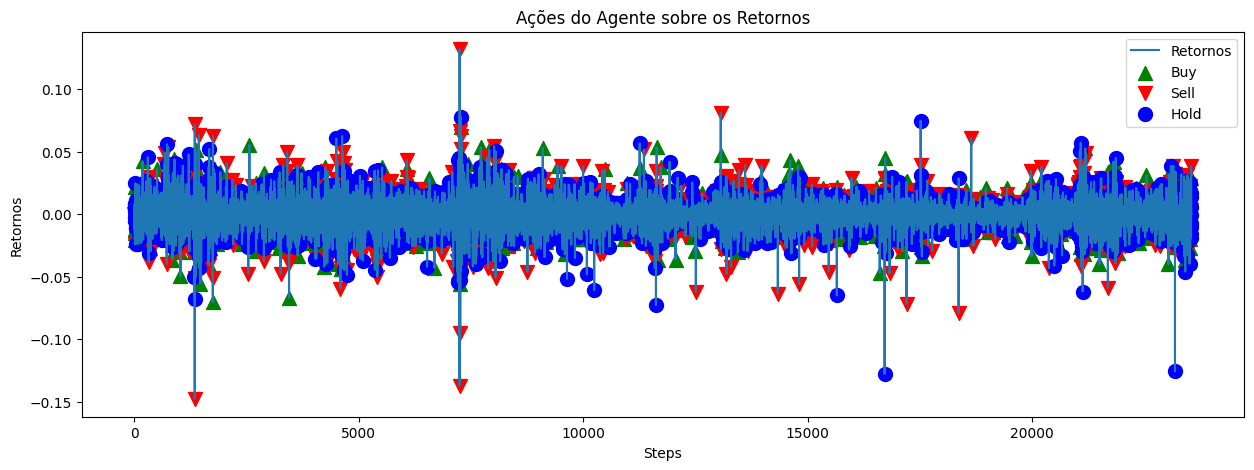

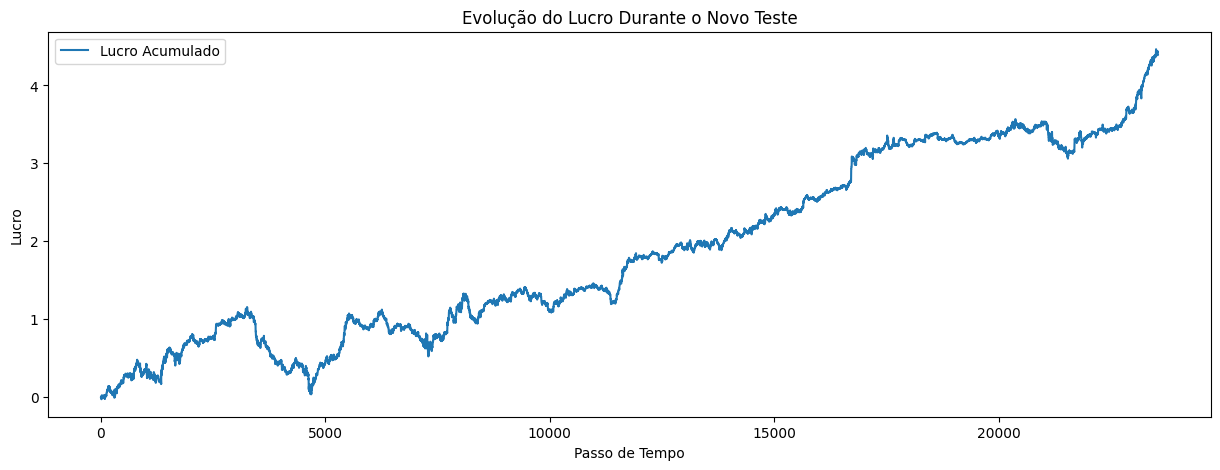

In [19]:
# Criação da instância do avaliador
evaluator = AgentEvaluator('save/best_policy_rl_course_eps2009.pkl')

# Definir o state mapper utilizado durante o treinamento
evaluator.set_state_mapper(state_mapper)

# Novo conjunto de dados de teste
#new_test_data = pd.read_csv('data/novo_teste.csv', index_col='closetime', parse_dates=True)
#new_test_data['diff_vol'] = np.log(new_test_data['Volume']).diff()
#new_test_data = keep_cols(['slope_diff_EMAs', 'slope_diff_RSIs', 'returns', 'HMM_Signals', 'Buy', 'Sell', 'diff_vol'], new_test_data)
new_test_env = Env(test_data)

# Executar a avaliação
actions, profits, states = evaluator.evaluate(new_test_env)

# Plotar ações e lucros
evaluator.plot_actions(actions, states)
evaluator.plot_profits(profits)


In [16]:
import pickle

class AgentEvaluator:
    def __init__(self, model_path, env):
        self.env = env
        self.agent = self.load_model(model_path)

    def load_model(self, model_path):
        with open(model_path, 'rb') as file:
            agent = pickle.load(file)
        return agent
    
    def act(self, state):
        s = self.state_mapper.transform(state)
        act_values = [self.Q.get((s, a), 0) for a in range(self.action_size)]
        return np.argmax(act_values)

    def evaluate(self):
        state = self.env.reset()
        done = False
        total_reward = 0
        actions = []
        states = []
        while not done:
            action = self.agent.act(state)
            next_state, reward, done = self.env.step(action)
            total_reward += reward
            actions.append(action)
            states.append(state)
            state = next_state
        return total_reward, actions, states

    def plot_agent_actions(self, actions, states):
        returns = [state[2] for state in states]  # assumindo que 'returns' é a terceira feature no estado
        buy_indices = [i for i, a in enumerate(actions) if a == 0]
        sell_indices = [i for i, a in enumerate(actions) if a == 1]
        hold_indices = [i for i, a in enumerate(actions) if a == 2]

        plt.figure(figsize=(15, 5))
        plt.plot(returns, label='Retornos')
        plt.scatter(buy_indices, [returns[i] for i in buy_indices], marker='^', color='g', label='Buy', s=100)
        plt.scatter(sell_indices, [returns[i] for i in sell_indices], marker='v', color='r', label='Sell', s=100)
        plt.scatter(hold_indices, [returns[i] for i in hold_indices], marker='o', color='b', label='Hold', s=100)
        plt.xlabel('Steps')
        plt.ylabel('Retornos')
        plt.title('Ações do Agente sobre os Retornos')
        plt.legend()
        plt.show()


In [17]:
# Carregar dados novos e criar um novo ambiente
#new_data = pd.read_csv('caminho/para/novos_dados.csv', index_col='closetime', parse_dates=True)
new_env = Env(test_data)

# Caminho para o modelo salvo
model_path = 'save/best_policy_rl_course_eps2009.pkl'

# Criar uma instância do AgentEvaluator com o modelo salvo e o novo ambiente
evaluator = AgentEvaluator(model_path, new_env)

# Avaliar a performance do agente nos novos dados
total_reward, actions, states = evaluator.evaluate()

# Plotar as ações do agente sobre os retornos
evaluator.plot_agent_actions(actions, states)


AttributeError: 'dict' object has no attribute 'act'